# TODO
- time-varying graphs
- table of results
- show combinatorics. why not NP hard. enumerate paths.
- remove $\mathcal{P}$. just describe a path with $x$ from the start?

# Topic references
- [Convex Optimization book](http://web.stanford.edu/~boyd/cvxbook/)
- [Additional Exercise 15.4: Allocation of interdiction effort](http://web.stanford.edu/~boyd/cvxbook/bv_cvxbook_extra_exercises.pdf)
- [Shortest path problem in graph theory](http://en.wikipedia.org/wiki/Shortest_path_problem)
- [Dijkstra's_algorithm](http://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)
- [Iterated weighted $\ell_1$ heuristic](http://stanford.edu/class/ee364b/lectures/l1_ext_slides.pdf)

# Allocating interdiction effort to catch a smuggler

We'll explore a game between a smuggler moving through a graph and a security team trying to catch him.

The smuggler moves along a directed graph (cycles are allowed) with $n$ nodes and $m$ edges from node $0$ (the source) to node $n-1$ (the destination).
Edge $j$ has evasion probability $p_j$, which is the probability that the smuggler moves along that edge undetected.
The detection events on the edges are independent, so the probability that the smuggler makes it to the destination undetected is $\prod_{j \in \mathcal{P}} p_j$, where $\mathcal{P} \subset \lbrace 0,\ldots, m-1\rbrace$ is the set of edges on the smuggler's path.
We assume that the smuggler knows the evasion probabilities and will take a path that maximizes the probability of making it to the destination node undetected.

The security team is trying to catch the smuggler as he moves through the graph.
They can control the evasion probabilities on the graph edges through, say, allocation of resources to the edges, assigning guards, etc.
We'll keep this abstract for now, and just consider that security can modify the evasion probabilities subject to some constraints.
Their goal is to choose evasion probabilities to minimize the chance that the smuggler gets through undetected.

# Transformations and mathematical formulation

We'll take the logarithm of all probabilities to make the problem amenable to convex optimization and simplify the remaining discussion.
This transforms products of variables (generally not convex) into sums of variables (convex!).

Let $c_j = \log(p_j)$.
As this is a one-to-one correspondence, we may refer to the 'edge detection probabilities' when we really mean to refer to their logarithm, $c$.
This should be clear from context and hopefully won't cause any confusion.

Given $c$ and a path $\mathcal{P}$, let $P(c, \mathcal{P})$ be the logarithm of the evasion probability of that path. That is, 

$$
P(c, \mathcal{P}) = \log \left( \prod_{j \in \mathcal{P}} p_j \right) = \sum_{j \in \mathcal{P}} \log(p_j) = \sum_{j \in \mathcal{P}} c_j.
$$

Define $P(c, \mathcal{P}) = -\infty$ if $\mathcal{P}$ is not a valid path from source to sink. We do this to implicity encode the constraint that the smuggler's path must be valid.

# Min/max game

We can now interpret this problem as a min/max game. The smuggler is trying to maximize his chance of getting through undetected by choosing $\mathcal{P}$, and security is trying to minimize the smuggler's chance by choosing $c$. That is, the smuggler is trying to maximize $P(c, \mathcal{P})$ while the security team is trying to minimize it.

We end up with a game with two 'moves'.
Security 'moves' first by choosing the edge evasion probabilities via $c$.
The smuggler 'moves' second (after $c$ is fixed) by choosing his path $\mathcal{P}$.

For security to make an optimal choice of edge evasion probabilities, they'll need to model what the smuggler will do when faced with any set of evasion probabilities. Thus, we'll let $P^\mathrm{opt}(c)$ be the optimal value of the problem

\\[
\begin{array}{ll}
  \mbox{maximize} & P(c, \mathcal{P}) \\
  \mbox{subject to} & \mathcal{P} \mbox{ is a valid path}.
\end{array}
\\]

$P^\mathrm{opt}(c)$ is the (logarithm of the) evasion probability of the smuggler if he picks an optimal path, knowing the values of $c$.

The security team's goal is then to minimize this quantity, subject to some constraints on $c$, which we'll denote by the set $\mathcal{C}$. Let $P^{\star}$ be the optimal value of 

\\[
\begin{array}{ll}
  \mbox{minimize} & P^{\mathrm{opt}}(c) \\
  \mbox{subject to} & c \in \mathcal{C}.
\end{array}
\\]

In the remainder, we'll first consider the smuggler's objective so as to obtain a convex formulation of 
$P^\mathrm{opt}(c)$, which we can then use to analyze and optimize the security team's objective.

# Helper functions

The next cell contains some helper functions for generating the examples and plotting the results. This is the majority of the code. The actual CVXPY optimization code is only a few lines. We'll go over the optimization code later in the notebook.

In [1]:
#%config InlineBackend.figure_format = 'pdf'
#%config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import cvxpy as cvx

from matplotlib import rcParams
rcParams.update({'font.size': 16})

def formGraph(N,mu,eta,buildings=None,seed=None,dummyNodes=False):
    ''' Form N by N grid of nodes, perturb by mu and connect nodes within eta.
        mu and eta are relative to 1/(N-1)
        
        buildings is a list of tuples (x,y,w,h)
    '''
    if seed is not None:
        np.random.seed(seed)
    
    mu = mu/(N-1)
    eta = eta/(N-1)
    
    # generate perterbed grid positions for the nodes
    pos = [(i + mu*np.random.randn(), j + mu*np.random.randn())\
       for i in np.linspace(0,1,N) for j in np.linspace(1,0,N)]
    
    #select out nodes that end up inside buildings
    if buildings is not None and buildings != []:
        pos2 = []
        for p in pos:
            inside = False
            for x,y,w,h in buildings:
                if x <= p[0] and p[0] <= x + w and y <= p[1] and p[1] <= y + h:
                    inside = True
                    break
            if not inside:
                pos2.append(p)
        pos = pos2
        
    # add dummy nodes for multiple entry/exit example
    if dummyNodes:
        pos = [(-.5,.5)] + pos + [(1.5,.5)]
    
    pos = dict(enumerate(pos))
    n = len(pos)
    
    # connect nodes with edges
    G = nx.random_geometric_graph(n,eta,pos=pos)
    
    # remove edges that cross buildings
    if buildings is not None and buildings != []:
        for e in list(G.edges()):
            blocked = False
            for x,y,w,h in buildings:
                if intersect(pos[e[0]],pos[e[1]],x,x+w,y,y+h):
                    blocked = True
            if blocked:
                G.remove_edge(*e)
    
    G = nx.DiGraph(G)
    
    # add edges connecting dummy nodes to nodes on left and right edges of grid
    if dummyNodes:
        for i in range(N):
            G.add_edge(0,i+1)
            G.add_edge(n-i-2,n-1)
    
    return G, pos

def showPaths(G,pos,edgeProbs=1.0,path=None,visibleNodes=None,Gnodes=None,Rnodes=None,guards=None):
    ''' Takes directed graph G, node positions pos, and edge probabilities.
        Optionally uses path (a list of edge indices) to plot the smuggler's path.
        
        edgeProbd gives the probabilities for all the edges, including hidden ones.
        
        path includes all the edges, including the hidden ones
        
        Gnodes and Rnodes denote the source and destination nodes, to be plotted green
        and red respectively.
        
        guards is a list of node indices for denoting guards with a black dot on the plot
    '''
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, aspect='equal')
    
    n = G.number_of_nodes()
    if visibleNodes is None:
        visibleNodes = G.nodes()
        
    # draw the regular interior nodes in the graph
    nx.draw_networkx_nodes(G,pos,nodelist=visibleNodes, edgecolors='k',
                           node_color='w',node_size=100,ax=ax)

    # draw the origin and destination nodes
    for nodes, color in zip([Gnodes,Rnodes],['g','r']):
        for color2, alpha in zip(['w',color],[1,.2]):
            nx.draw_networkx_nodes(G,pos,
                           nodelist=nodes,
                           node_color=color2,
                           edgecolors='k',
                           node_size=200,
                           ax=ax,alpha=alpha)

    # draw guard nodes
    if guards is not None:
        nx.draw_networkx_nodes(G,pos,nodelist=guards,node_color='k',
                               node_size=100,ax=ax)
      
        
    if path is None:
        alpha = 1
    else:
        alpha = .15
        
    # start messing with edges
    edge2ind = {e:i for i,e in enumerate(G.edges())}
    ind2edge = {i:e for i,e in enumerate(G.edges())}
    
    # only display edges between non-dummy nodes
    visibleEdges = [i for i in range(len(edge2ind)) if ind2edge[i][0] in visibleNodes and ind2edge[i][1] in visibleNodes]
    
    edgelist = [ind2edge[i] for i in visibleEdges]
    
    if isinstance(edgeProbs,float):
        edgeProbs = [edgeProbs]*G.number_of_edges()
        
    p = [edgeProbs[i] for i in visibleEdges]

    # draw edges of graph, make transparent if we're drawing a path over them
    edges = nx.draw_networkx_edges(G,pos,edge_color=p,width=4,
                                   edge_cmap=plt.cm.RdYlGn,arrows=False,edgelist=edgelist,edge_vmin=0.0,
                                   edge_vmax=1.0,ax=ax,alpha=alpha)

    # draw the path, only between visible nodes
    if path is not None:
        visiblePath = [i for i in path if ind2edge[i][0] in visibleNodes and ind2edge[i][1] in visibleNodes]
        path_pairs = [ind2edge[i] for i in visiblePath]
        path_colors = [edgeProbs[i] for i in visiblePath]
        edges = nx.draw_networkx_edges(G,pos,edge_color=path_colors,width=8,
                                       edge_cmap=plt.cm.RdYlGn,edgelist=path_pairs,arrows=False,edge_vmin=0.0,
                                   edge_vmax=1.0)
    
    fig.colorbar(edges,label='Evasion probability')

    ax.axis([-0.05,1.05,-0.05,1.05])
    #ax.axis('tight')
    #ax.axis('equal')
    ax.axis('off')
    
    return fig, ax
    
def optPath(G,p):
    ''' Find the optimal smuggler's path in directed graph G
        with edge evasion probabilities p and dictionary
        edge2ind bringing node pairs to edge indices
    '''
    edge2ind = {e:i for i,e in enumerate(G.edges())}
    H = G.copy()
    p = np.minimum(p,1)
    w = -np.log(p)
    n = H.number_of_nodes()
    
    for i in H:
        for j in H[i]:
            H[i][j]['w'] = w[edge2ind[(i,j)]]
            
    path = nx.shortest_path(H,0,n-1,'w')
    #path = nx.astar_path(H,0,n-1,weight='w')
            
    foo = [edge2ind[(i,j)] for i,j in zip(path[:-1],path[1:])]
    x = np.zeros_like(p)
    x[foo] = 1
    return x

def intersect(p1,p2,xmin,xmax,ymin,ymax):
    '''determine if a rectangle given by xy limits blocks the line of sight between p1 and p2'''

    block = False
    
    # if either point inside block
    for p in [p1,p1]:
        if xmin <= p[0] and p[0] <= xmax and ymin <= p[1] and p[1] <= ymax:
            return True
    
    # if the two points are equal at this stage, then they are outside the block
    if p1[0] == p2[0] and p1[1] == p2[1]:
        return False
    
    
    if p2[0] != p1[0]:
        for x in [xmin,xmax]:
            alpha = (x-p1[0])/(p2[0] - p1[0])
            y = p1[1] + alpha*(p2[1] - p1[1])

            if 0 <= alpha and alpha <= 1 and ymin <= y and y <= ymax:
                return True
            
    if p2[1] != p1[1]:
        for y in [ymin,ymax]:
            alpha = (y-p1[1])/(p2[1] - p1[1])
            x = p1[0] + alpha*(p2[0] - p1[0])

            if 0 <= alpha and alpha <= 1 and xmin <= x and x <= xmax:
                return True
        
    return False

def getGuardEffects(G,pos,guardIdxs,buildings=None,dummyNodes=None):
    ''' for n guards and m edges, return an m by n matrix giving the
        effect of each guard on the evasion probabilities of each edge
        in the graph.
        
        Ignore dummy nodes, if any. Guards cannot see through buildings.
        
        guardIdxs is a list of the node indices where we would consider placing
        guards
        
        Return the log of the detection probabilities for each guard.
    
    '''
    def evadeProb(x,radius=.2):
        r = np.linalg.norm(x)/radius
        return min(r+.1,1)
    
    m = G.number_of_edges()
    if buildings is None:
        buildings = []
    if dummyNodes is None:
        dummyNodes = []
    
    
    ind2edge = {i:e for i,e in enumerate(G.edges())}
    edgeCenters = []
    for e in G.edges():
        edgeCenters.append((np.array(pos[e[0]]) + np.array(pos[e[1]]))/2)
        
    edgeCenters = np.array(edgeCenters)
    numGuards = len(guardIdxs)
    edgeVals = np.zeros((m,numGuards))
    
    for i,gid in enumerate(guardIdxs):
        for j in range(m):
            blocked = False
            for x,y,w,h in buildings:
                if intersect(edgeCenters[j,:],pos[gid],x,x+w,y,y+h):
                    blocked = True
                    break
            e = ind2edge[j]
            if e[0] in dummyNodes or e[1] in dummyNodes:
                blocked = True
            if not blocked:
                edgeVals[j,i] += np.log(evadeProb(pos[gid]-edgeCenters[j,:],.3))
    return edgeVals

def get_a(G,seed=None):
    '''
    Generate a random value in [0,1] for each edge in the graph.
    For directed graphs, directed edges between the same nodes should have the same value
    '''
    if seed is not None:
        np.random.seed(seed)
    m = G.number_of_edges()
    a = np.zeros((m))
    edge2ind = {e:i for i,e in enumerate(G.edges())}
    for e in G.edges():
        a[edge2ind[e]] = np.random.rand()
        e2 = (e[1],e[0])
        if e2 in edge2ind:
            a[edge2ind[e2]] = a[edge2ind[e]]
    return a

# Smuggler's objective

The smuggler chooses a path $\mathcal{P}$ only after $c$ is fixed.
His goal is to find a valid path in the graph which maximizes $\sum_{j \in \mathcal{P}} c_j$.
Note that this problem can be cast and solved exactly as a [shortest path problem in graph theory](http://en.wikipedia.org/wiki/Shortest_path_problem).
We formulate it here as a convex problem so that the security team can use the model to thwart the smuggler.

We'll denote possible paths with a Boolean decision variable $x \in \lbrace 0,1 \rbrace^m$, where $x_j = 1$ denotes $j \in \mathcal{P}$. Note that this allows us to write the smuggler's objective as

$$
\sum_{j \in \mathcal{P}} c_j = \sum_{j=0}^{n-1} c_j x_j = c^T x.
$$

The $x$ variable needs to satisfy certain constraints to represent a valid path. Firstly, the number of times the path exits the source node must be exactly one more than the number of times it enters the source node. Similarly, the number of times the path enters the destination node must be exactly one more than the number of times it exits destination node. For all other nodes in the graph, the number of times the path enters and exits the node must be equal. These constraints can be represented as $Ax = b$, where

\\[
b_i = \begin{cases} 
-1 & i = 0 \\
+1 & i = n-1\\
0 & \mbox{otherwise,}
\end{cases}
\\]

\\[
A_{ij} = 
\begin{cases} 
+1 & \mbox{if edge $j$ enters node $i$} \\
-1 & \mbox{if edge $j$ exits node $i$} \\
0 & \mbox{otherwise.}
\end{cases}
\\]

The smuggler's problem can then be written so that $P^\mathrm{opt}(c)$ is the optimum value of the problem

\\[
\begin{array}{ll}
  \mbox{maximize} & c^T x \\
  \mbox{subject to} & A x = b\\
  & x \in \lbrace 0,1 \rbrace^m.
\end{array}
\\]

This is a linear problem with Boolean variables, which is not convex, but we can transform it into a convex problem by relaxing the Boolean constraints to get the linear program

\\[
\begin{array}{ll}
  \mbox{maximize} & c^T x \\
  \mbox{subject to} & A x = b\\
  & x \geq 0,
\end{array}
\\]
with optimum value $P^{\mathrm{opt}}_\mathrm{R}(c)$.

It turns out that this relaxed convex problem solves the original Boolean problem *exactly*.
That is, $P^{\mathrm{opt}}(c) = P^{\mathrm{opt}}_\mathrm{R}(c)$, so we will only write $P^{\mathrm{opt}}$ in the remainder.
In addition, the solution to the LP, $x^\star$, will be Boolean when there is a unique optimal path.
In the presence of multiple optimal paths, the $x^\star$ may have fractional entries, but an optimal path can still be recovered.

For the purposes of the security team, we'll only need that the Boolean and LP optimal values are equal.
Before continuing on to security's perspective, we'll look at an example of the smuggler choosing an optimal path in a given graph.

# Smuggler's path example
We'll solve the smuggler's problem on an example network to see an example of an optimal path.

We'll create an $N \times N$ grid of points with small perturbations to make the graph irregular, connecting two nodes with two directed edges (one going each way) if the nodes are within distance $\eta$ of each other. Pairs of edges $(i,j)$ and $(j,i)$ will have identical evasion probabilities, i.e., the evasion probability is the same in either direction between two connected nodes. The evasion probability will be distributed like $p_j = e^{-a_j}$, where $a_j$ is a uniform random variable over the interval $\left[0,1\right]$.

The smuggler will find an optimal path from node $0$ in the upper-left corner of the graph plot to node $n-1$ in the lower-right corner of the graph plot.

We show the graph with the edge evasion probabilities below.

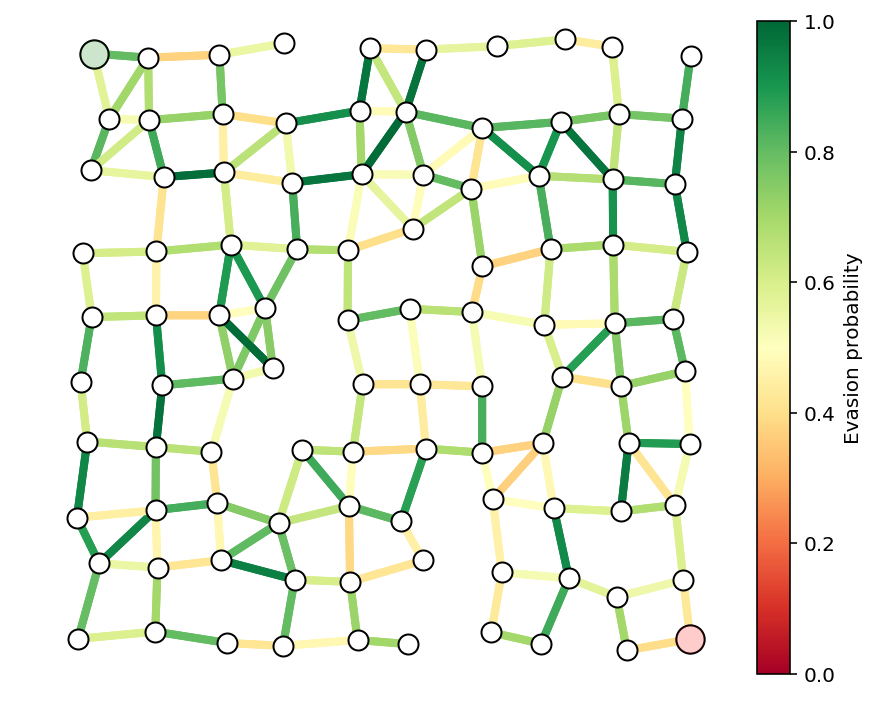

In [2]:
N = 10
G, pos = formGraph(N,.12,1.2,seed=5)
n = G.number_of_nodes()

a = get_a(G,seed=2)
p = np.exp(-a)    

fig, ax = showPaths(G,pos,p,Gnodes=[0],Rnodes=[n-1])

We form the smuggler's relaxed convex problem and solve it to find his optimal path. We plot the path below.

In [3]:
A = nx.incidence_matrix(G,oriented=True).toarray()
n,m = A.shape

b = np.zeros(n)
b[0] = -1
b[n-1] = 1

c = np.log(p)

edge2ind = {e: i for i,e in enumerate(G.edges())}

B = np.zeros((int(m/2),m))
count = 0
for i in G:
    for j in G[i]:
        if i < j:
            B[count,edge2ind[(i,j)]] = 1
            B[count,edge2ind[(j,i)]] = -1
            count += 1


x = cvx.Variable(shape=(m))
constr = [A*x == b,x>=0, x <= 1]
cvx.Problem(cvx.Maximize(x.T*c),constr).solve(verbose=True)
x = np.array(x.value).flatten()


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.143e+01  -4.487e+02  +5e+02  6e-03  7e-09  1e+00  8e-01    ---    ---    1  1  - |  -  - 
 1  +5.350e+01  -3.770e+01  +9e+01  1e-03  1e-08  2e-01  1e-01  0.8499  3e-02   0  0  0 |  0  0
 2  +1.744e+01  -8.892e+00  +3e+01  3e-04  1e-08  5e-02  4e-02  0.7794  9e-02   0  0  0 |  0  0
 3  +9.649e+00  +5.039e-01  +9e+00  1e-04  7e-09  2e-02  1e-02  0.6868  5e-02   0  0  0 |  0  0
 4  +5.570e+00  +4.334e+00  +1e+00  1e-05  5e-09  2e-03  2e-03  0.9371  8e-02   0  0  0 |  0  0
 5  +5.053e+00  +4.878e+00  +2e-01  2e-06  2e-09  3e-04  3e-04  0.8747  2e-02   1  0  0 |  0  0
 6  +4.969e+00  +4.961e+00  +8e-03  9e-08  2e-09  1e-05  1e-05  0.9770  2e-02   1  0  0 |  0  0
 7  +4.965e+00  +4.965e+00  +9e-05  1e-09  4e-11  1e-07  1e-07  0.9890  1e-04   1  0  0 |  0  0
 8  +4.965e+00  +4.965e+00  +1e-06  1e-11  7e-

The evasion probability of the smuggler's optimal path is 6.976181e-03, or 0.698%.


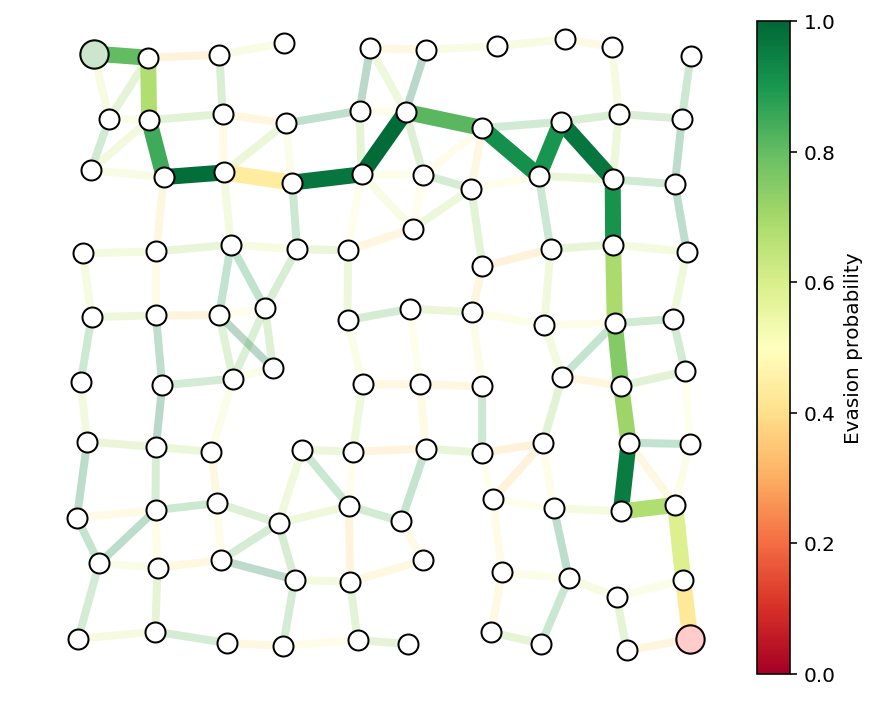

In [4]:
path = list(np.flatnonzero(x > .1))
showPaths(G,pos,p,path,Gnodes=[0],Rnodes=[n-1])
print("The evasion probability of the smuggler's "
      "optimal path is %e, or %.3f%%."%(np.exp(x.dot(c)), np.exp(x.dot(c))*100))

We run a discrete graph-theoretic shortest path algorithm on the same graph to check that we get the same optimal path.
The function `optPath` is using the NetworkX Python package and [Dijkstra's_algorithm](http://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) to compute the optimal path.

The evasion probability of the smuggler's optimal path is 6.976181e-03, or 0.698%.


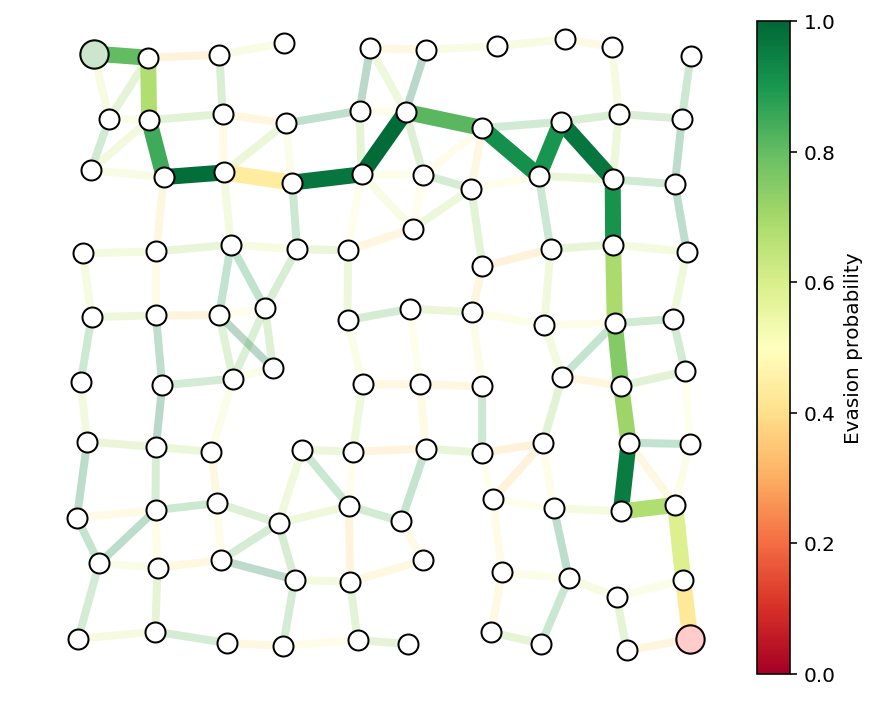

In [5]:
y = optPath(G,p)
path = list(np.flatnonzero(y > .1))
showPaths(G,pos,p,path,Gnodes=[0],Rnodes=[n-1])
print("The evasion probability of the smuggler's "
      "optimal path is %e, or %.3f%%."%(np.exp(y.dot(c)), np.exp(y.dot(c))*100))

# Security's objective

The security team's goal is to minimize $P^\mathrm{opt}(c)$, subject to some constraints (say, limits on budget or personnel), which we'll denote by $c \in \mathcal{C}$:

\\[
\begin{array}{ll}
  \mbox{minimize} & P^{\mathrm{opt}}(c) \\
  \mbox{subject to} & c \in \mathcal{C}.
\end{array}
\\]

But note that $P^{\mathrm{opt}}(c)$ is the optimal value of the problem

\\[
\begin{array}{ll}
  \mbox{maximize} & c^T x \\
  \mbox{subject to} & A x = b\\
  & x \geq 0.
\end{array}
\\]

We'd like to combine these two optimization problems into a single problem for the security team to solve, but this is problematic as the variables of one problem, $x$, are multiplied with the variables of the other, $c$, which is not a convex objective in general. To get around this, we'll take the dual (Chapter 5 of the [Convex Optimization book](http://web.stanford.edu/~boyd/cvxbook/)) of the smuggler's problem.

Let $D^\mathrm{opt}(c)$ denote the optimal value of the dual of the smuggler's problem, which is

\\[
\begin{array}{ll}
  \mbox{minimize} & b^T \lambda \\
  \mbox{subject to} & A^T \lambda \geq c,
\end{array}
\\]
with dual variable $\lambda$.

Duality theory guarantees that $D^\mathrm{opt}(c) = P^{\mathrm{opt}}(c)$, which allows us to write the security team's problem as

\\[
\begin{array}{ll}
  \mbox{minimize} & D^{\mathrm{opt}}(c) \\
  \mbox{subject to} & c \in \mathcal{C},
\end{array}
\\]
which we can rewrite as the single optimization problem

\\[
\begin{array}{ll}
  \mbox{minimize} & b^T \lambda \\
  \mbox{subject to} & A^T \lambda \geq c\\
  &c \in \mathcal{C},
\end{array}
\\]
where $c$ and $\lambda$ are the optimization variables.

We will denote the optimal value of this problem as $P^\star$. By solving to find $c^\star$, the security team will have optimally allocated resources to make detection of the smuggler as likely as possible.

# Security example

We'll consider security's problem on the same network as the last example with the edge evasion probabilities modeled as $p_j = e^{-a_j r_j}$, where $r_j \in \mathbf{R}_+$ denotes the effort (say, yearly budget) allocated to edge $j$. We'll assume $a_j \in \mathbf{R}_{++}$ are given and represent the cost involved in securing an edge. As in the last example, $a_j$ is a uniform random variable over the interval $\left[0,1\right]$.

We'll use the same random seed as the last example, so the last example corresponds to the specific allocation $r_j = 1$ for all $j$ in the current model. We'll use this to compare the detection probability of a naive, uniform effort allocation against the optimal allocation.

For this example, we'll impose a maximum budget constraint $\sum_{j=0}^{m-1} r_j = m$, and a uniform spending limit on each edge, $r_j \leq R$.

We'll also constrain that the evasion probability is equal in both directions. That is, edge $(i,j)$ and edge $(j,i)$ have equal evasion probabilities. We'll enforce that constraint with $Br = 0$, for some matrix $B$.

The final model is
\\[
\begin{array}{ll}
  \mbox{minimize} & b^T \lambda \\
  \mbox{subject to} & A^T \lambda \geq c \\
  & c_j = -a_j r_j \\
  & Br = 0 \\
  & 0 \leq r \leq R\\
  &\mathbf{1}^T r = m
\end{array}
\\]

We solve the model below with $R=5$ and report the evasion probability of the smuggler's optimal path.

In [6]:
nu = cvx.Variable(shape=(n))
r = cvx.Variable(shape=(m))
constr = [A.T*nu >= -cvx.multiply(a,r), cvx.sum(r) == m, r >= 0, B*r == 0, r <= 5]
cvx.Problem(cvx.Minimize(nu.T*b),constr).solve(verbose=True)
nu = np.array(nu.value).flatten()
r = np.array(r.value).flatten()


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.786e-16  -2.334e+03  +3e+03  2e-03  3e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.124e+00  -4.008e+02  +4e+02  3e-04  2e-01  2e-01  4e-01  0.8341  7e-03   1  1  1 |  0  0
 2  -5.775e+00  -1.458e+02  +2e+02  1e-04  4e-02  1e-01  1e-01  0.8624  2e-01   1  1  1 |  0  0
 3  -9.593e+00  -8.916e+01  +9e+01  6e-05  3e-02  7e-02  8e-02  0.5173  2e-01   1  1  1 |  0  0
 4  -1.277e+01  -5.372e+01  +4e+01  3e-05  2e-02  4e-02  4e-02  0.5472  1e-01   1  1  1 |  0  0
 5  -1.708e+01  -3.437e+01  +2e+01  1e-05  1e-02  2e-02  2e-02  0.6462  1e-01   1  1  1 |  0  0
 6  -1.841e+01  -3.042e+01  +1e+01  8e-06  8e-03  1e-02  1e-02  0.4291  3e-01   1  1  2 |  0  0
 7  -1.982e+01  -2.590e+01  +7e+00  4e-06  5e-03  6e-03  6e-03  0.7148  3e-01   1  1  1 |  0  0
 8  -2.063e+01  -2.453e+01  +4e+00  2e-06  3e-

In [7]:
print("The evasion probability of the smuggler's optimal path is %e."%(np.exp(nu.dot(b)),))
print("The smuggler's chance of evasion is %.2f times smaller than with the uniform resource allocation."%(np.exp(x.dot(c))/np.exp(nu.dot(b))))

The evasion probability of the smuggler's optimal path is 2.887804e-10.
The smuggler's chance of evasion is 24157387.15 times smaller than with the uniform resource allocation.


Here we plot the resulting edge evasion probabilities from the optimal allocation.

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1044d2910>)

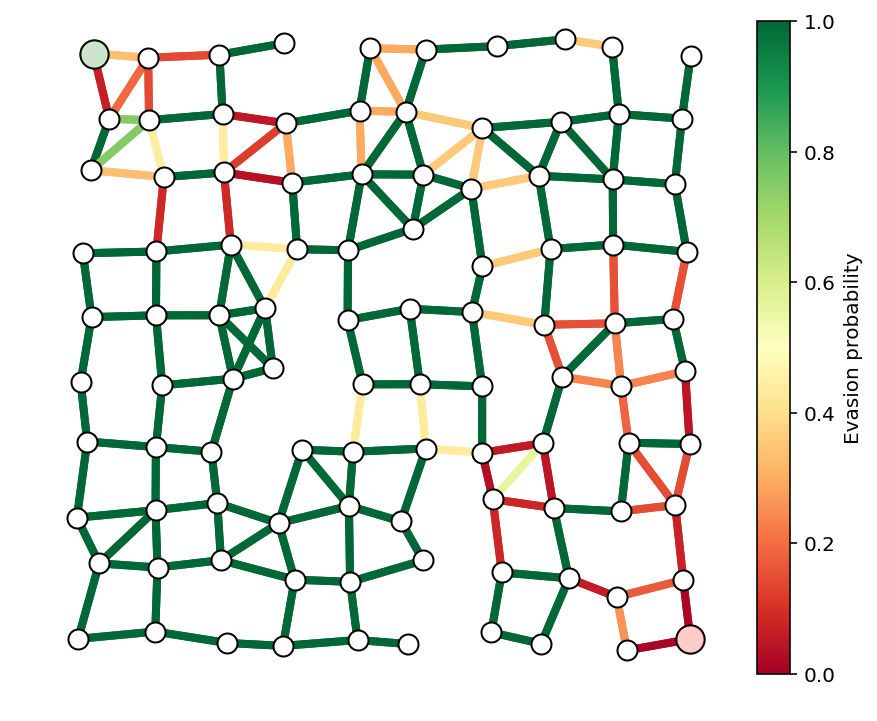

In [8]:
p = np.exp(-a*r)
showPaths(G,pos,p,Gnodes=[0],Rnodes=[n-1])

We can now solve the smuggler's problem with these optimal resource allocations, but we won't recover a Boolean solution for $x^{\star}$ because the optimal path is not unique. Note, however, that the optimal evasion probability is the same.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.833e+01  -1.079e+03  +1e+03  6e-03  7e-09  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  +6.010e+01  -4.132e+02  +5e+02  3e-03  6e-09  5e-01  7e-01  0.6890  1e-01   0  0  0 |  0  0
 2  +2.943e+01  -6.339e+01  +1e+02  5e-04  3e-09  1e-01  1e-01  0.8170  2e-02   0  0  0 |  0  0
 3  +2.262e+01  +5.776e+00  +2e+01  9e-05  1e-09  2e-02  2e-02  0.8386  2e-02   0  0  0 |  0  0
 4  +2.202e+01  +2.131e+01  +7e-01  4e-06  1e-10  9e-04  1e-03  0.9778  2e-02   0  0  0 |  0  0
 5  +2.197e+01  +2.196e+01  +8e-03  4e-08  6e-12  1e-05  1e-05  0.9890  1e-04   1  0  0 |  0  0
 6  +2.197e+01  +2.197e+01  +9e-05  5e-10  3e-12  1e-07  1e-07  0.9890  1e-04   1  0  0 |  0  0
 7  +2.197e+01  +2.197e+01  +7e-06  8e-11  2e-10  9e-09  1e-08  0.9201  6e-04   2  0  0 |  0  0
 8  +2.197e+01  +2.197e+01  +7e-07  5e-10  9e-

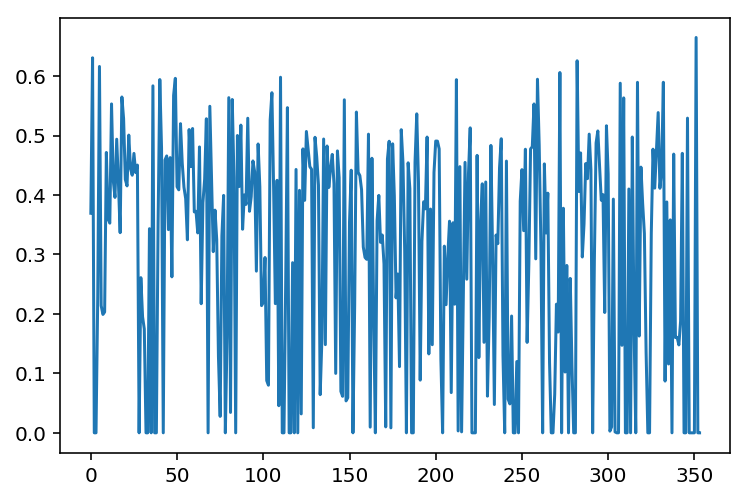

In [9]:
c = np.log(p)
x = cvx.Variable(shape=(m))
constr = [A*x == b,x>=0, x <= 1]
cvx.Problem(cvx.Maximize(x.T*c),constr).solve(verbose=True)
x = np.array(x.value).flatten()

plt.plot(x)
print("The evasion probability of the smuggler's optimal path is %e."%(np.exp(x.dot(c)),))

We use [Dijkstra's_algorithm](http://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) again to recover an optimal path for the smuggler in the case that the path is not unique and plot it below. We again check that the detection probability is what we predicted previously.

The evasion probability of the smuggler's optimal path is 2.887804e-10.


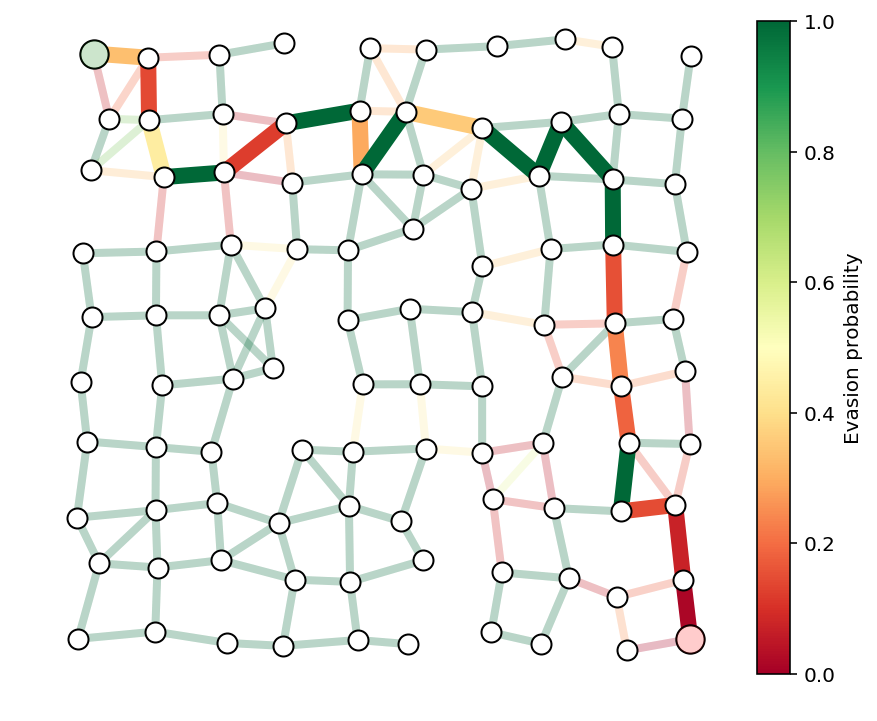

In [10]:
x = optPath(G,p)
path = list(np.flatnonzero(x > .1))
showPaths(G,pos,p,path,Gnodes=[0],Rnodes=[n-1])
print("The evasion probability of the smuggler's optimal path is %e."%(np.exp(x.dot(c)),))

# Guard placement example

We can now go through a more advanced example.

In the previous example, security had direct control over the evasion probability on each edge. In this section, we'll consider an example where security can only control the edge probabilities through the placement of guards, each of whom will effect edges which are close to them.

In the last example, the security team put a lot of effort on edges near the source and destination nodes. We'll make the team's job a bit harder by allowing the smuggler's path to start at any node on the left side of the graph, and end at any node on the right. This will force the team to allocate resources more evenly over the graph.

To make things even more interesting, we'll add 'buildings' in the region covered by the graph. The smuggler and security will have to work around the buildings. That is, no node is located inside a building, no edge crosses through a building, and guards can't see through building walls, restricting their line-of-sight and effect on nearby edges.

## Multiple sources and destinations

To allow for multiple source and destination nodes without changing the convex formulation, we'll add a dummy source node and a dummy sink node. The source node will have edges going to each node in the graph
on the left hand side. The sink node will have edges going to each node on the right. We'll ensure that these dummy edges always have evasion probability 1. The plot below demonstrates the idea. We won't plot the dummy nodes or edges, but we will highlight the 'new' source and sink nodes with light green and red as before.

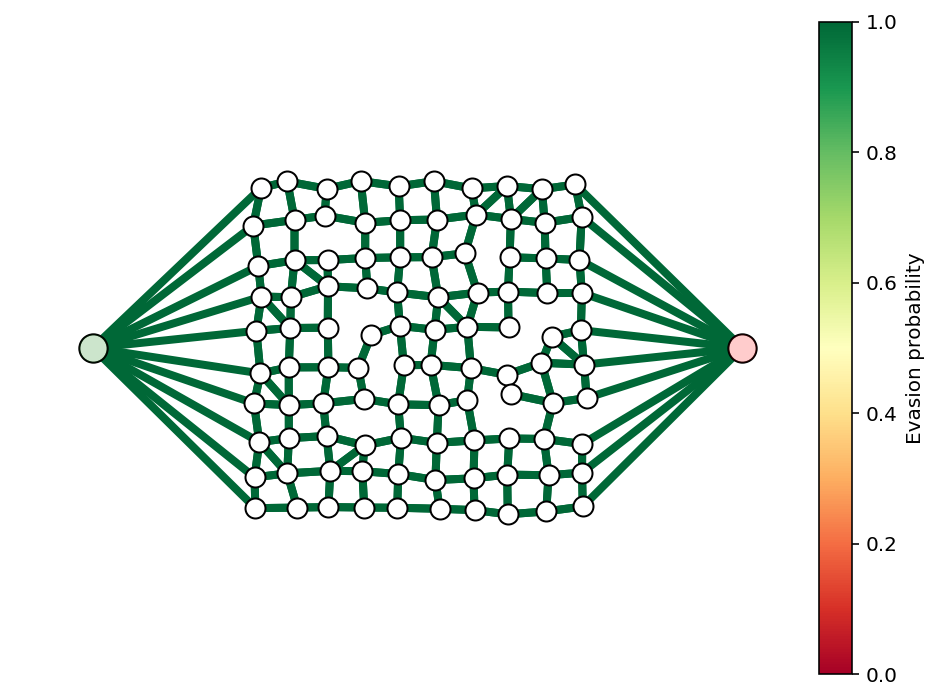

In [11]:
# show dummy source and destination node
N = 10
G, pos = formGraph(N,.1,1.2,seed=1,dummyNodes=True)
n = G.number_of_nodes()
fig, ax = showPaths(G,pos,Gnodes=[0],Rnodes=[n-1])
ax.axis([-.6,1.6,-.05,1.05]);

## Guards

The security team will select a subset of guards to place in the graph. Each guard will have a profile, which gives his effect on the edge evasion probabilities. The guard's effect will be a function of his distance to the center of each edge. In principle, guards could be placed anywhere in the region occupied by the graph, but we'll only consider guards placed on node positions to make them easy to visualize.

An example of a few guards and the resulting evasion probabilities is shown below.

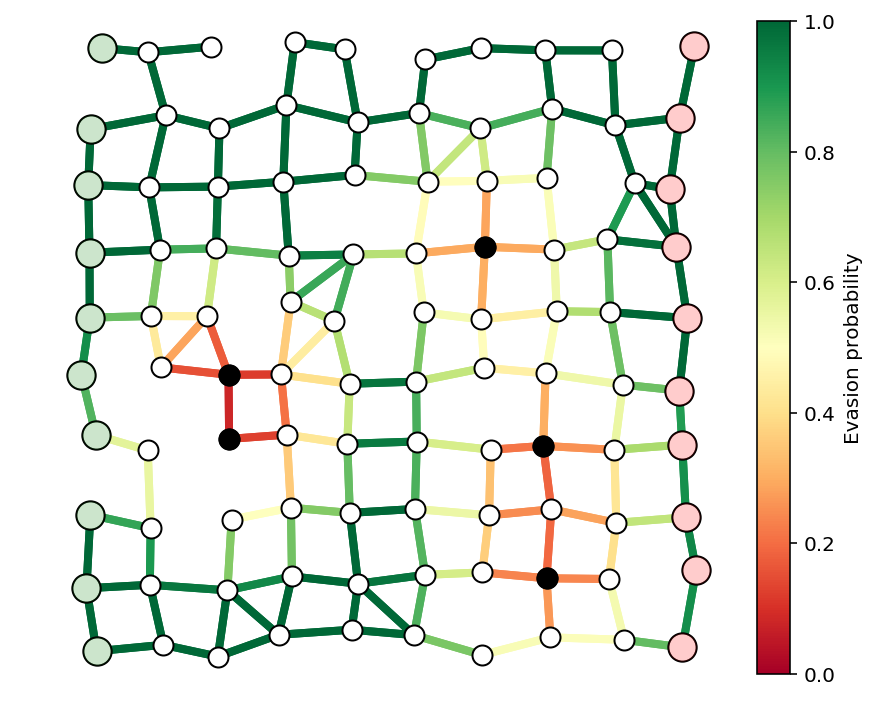

In [12]:
N = 10
k = 5
G, pos = formGraph(N,.1,1.2,seed=3,dummyNodes=True)
n = G.number_of_nodes()
guardIdxs = list(np.random.choice(list(range(N+1,n-N-1)),k,replace=False))

visibleNodes = range(1,n-1)
Gnodes = range(1,N+1)
Rnodes = range(n-2,n-N-2,-1)

edgeVals = getGuardEffects(G,pos,guardIdxs,dummyNodes=[0,n-1])
edgeProbs = edgeVals.sum(axis=1)
edgeProbs = np.exp(edgeProbs)

fig, ax = showPaths(G,pos,edgeProbs,visibleNodes=visibleNodes,Gnodes=Gnodes,Rnodes=Rnodes,guards=guardIdxs)

## Buildings

We'll also add buildings, which will modify the graph topology and also restrict the view of the guards.

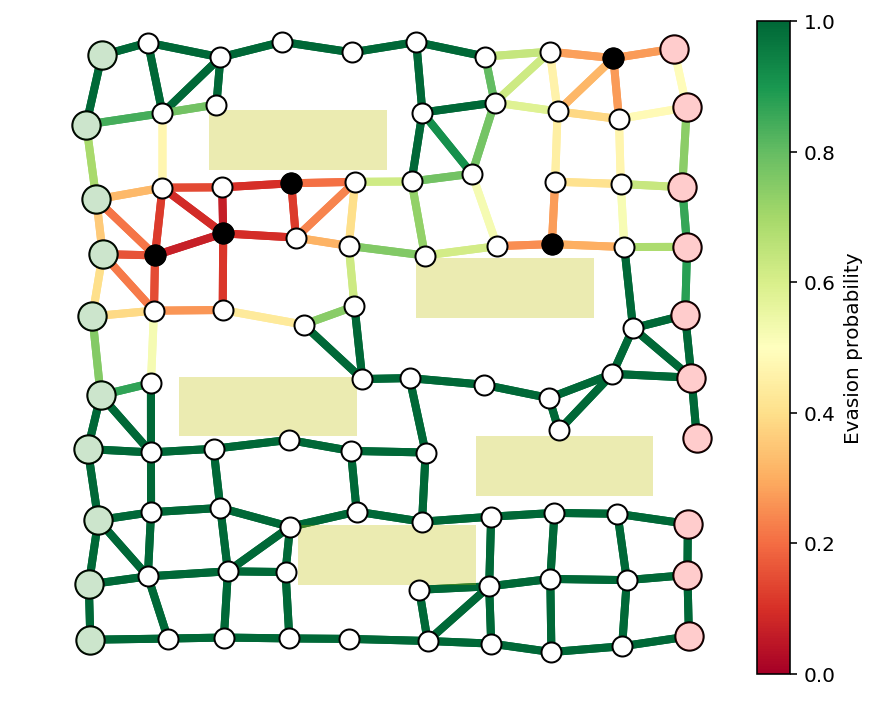

In [13]:
N = 10
k = 5
buildings = [(.2,.8,.3,.1),
             (.35,.1,.3,.1),
             (.55,.55,.3,.1),
             (.15,.35,.3,.1),
             (.65,.25,.3,.1)]

G, pos = formGraph(N,.11,1.25,buildings=buildings,seed=1,dummyNodes=True)
n = G.number_of_nodes()
guardIdxs = list(np.random.choice(list(range(N+1,n-N-1)),k,replace=False))

visibleNodes = range(1,n-1)
Gnodes = range(1,N+1)
Rnodes = range(n-2,n-N-2,-1)

edgeVals = getGuardEffects(G,pos,guardIdxs,buildings=buildings,dummyNodes=[0,n-1])
edgeProbs = edgeVals.sum(axis=1)
edgeProbs = np.exp(edgeProbs)

fig, ax = showPaths(G,pos,edgeProbs,visibleNodes=visibleNodes,Gnodes=Gnodes,Rnodes=Rnodes,guards=guardIdxs)

for x,y,w,h in buildings:
    rect = plt.Rectangle((x,y),w,h,fc='y',alpha=.3)
    ax.add_patch(rect)

# Example to solve

We'll solve a larger example with buildings, guards, and multiple source and destination nodes. We'll consider a guard at every interior node of the graph, and try to find a limited number, say 10, to secure the graph as well as possible.

# TODO
- optimization formulation
- this one turns out to be a 'true' integer program, unlike the last
- use iterative reweighting to get boolean solution
- use relaxation to give bounds on distance to true optimal

In [14]:
N = 17
buildings = [(.2,.8,.3,.1),
             (.35,.1,.3,.1),
             (.55,.55,.3,.1),
             (.15,.35,.3,.1),
             (.65,.3,.3,.1)]

G, pos = formGraph(N,.11,1.25,buildings=buildings,seed=0,dummyNodes=True)
n = G.number_of_nodes()
guardIdxs = list(range(N+1,n-N-1))

visibleNodes = range(1,n-1)
Gnodes = range(1,N+1)
Rnodes = range(n-2,n-N-2,-1)

edgeVals = getGuardEffects(G,pos,guardIdxs,buildings=buildings,dummyNodes=[0,n-1])
edgeProbs = edgeVals.sum(axis=1)
edgeProbs = np.exp(edgeProbs)

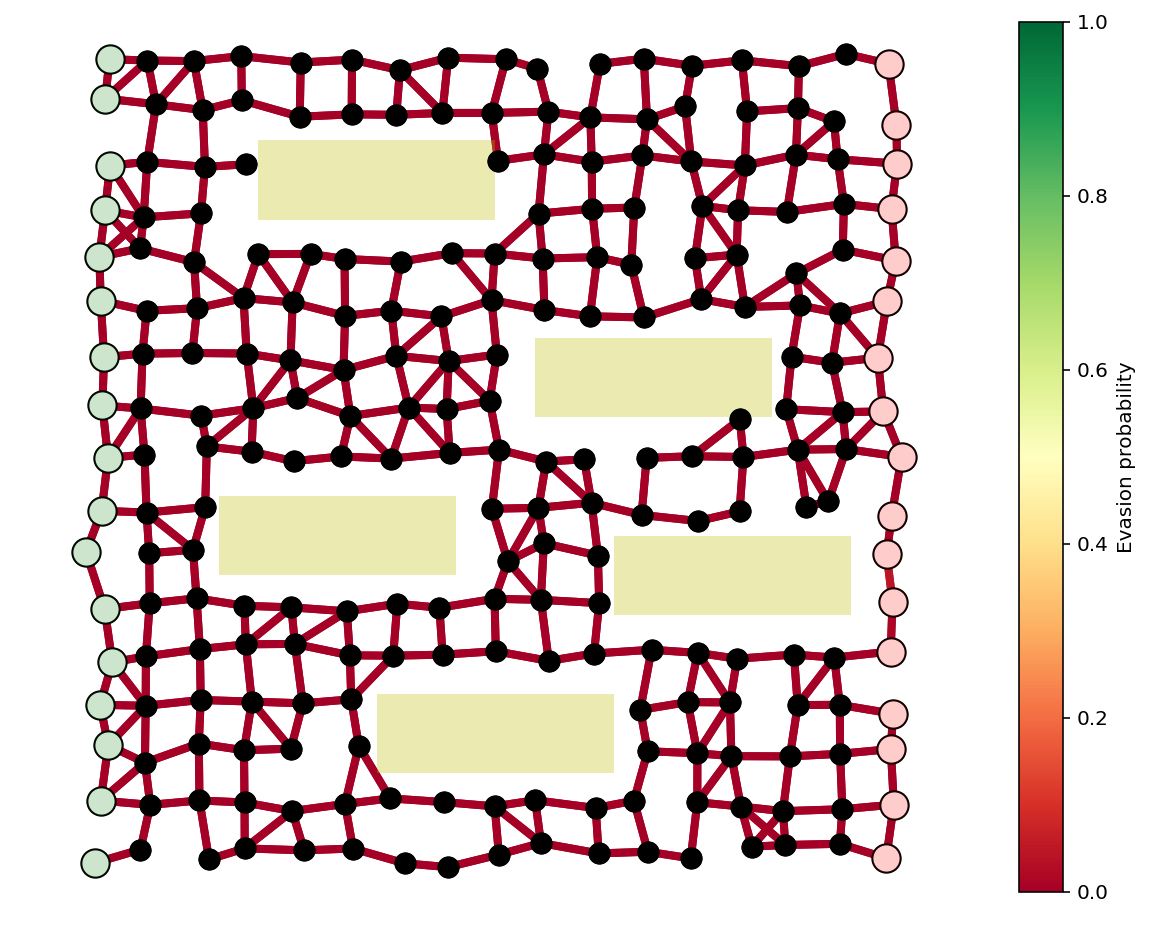

In [15]:
fig, ax = showPaths(G,pos,edgeProbs,visibleNodes=visibleNodes,Gnodes=Gnodes,Rnodes=Rnodes,guards=guardIdxs)

fig.set_size_inches((16,8))
for x,y,w,h in buildings:
    rect = plt.Rectangle((x,y),w,h,fc='y',alpha=.3)
    ax.add_patch(rect)

In [16]:
A = nx.incidence_matrix(G,oriented=True).toarray()
n,m = A.shape
numGuards = len(guardIdxs)

b = np.zeros(n)
b[0] = -1
b[n-1] = 1

eps = 1e-1
w = np.ones(numGuards)

for i in range(2):
    nu = cvx.Variable(shape=(n,1))
    r = cvx.Variable(shape=(numGuards,1))
    constr = [A.T*nu >= edgeVals*r, cvx.sum(r) == 10, r >= 0, r <= 1]
    cvx.Problem(cvx.Minimize(nu.T*b/100 + r.T*w),constr).solve(verbose=True)
    nu = np.array(nu.value).flatten()
    r = np.array(r.value).flatten()
    w = 1/(eps+np.abs(r))


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.000e+01  -2.398e+02  +3e+03  6e-01  1e+01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  +1.001e+01  -2.059e+01  +9e+02  8e-02  3e+00  2e+00  7e-01  0.9803  3e-01   1  1  1 |  0  0
 2  +1.001e+01  +8.035e+00  +8e+01  5e-03  2e-01  3e-01  7e-02  0.9237  2e-02   1  1  1 |  0  0
 3  +9.984e+00  +9.720e+00  +1e+01  5e-04  5e-02  3e-02  9e-03  0.8741  2e-02   1  1  1 |  0  0
 4  +9.909e+00  +9.837e+00  +3e+00  7e-05  1e-02  6e-03  2e-03  0.7905  7e-02   1  1  1 |  0  0
 5  +9.887e+00  +9.859e+00  +1e+00  2e-05  5e-03  2e-03  1e-03  0.6710  9e-02   1  1  1 |  0  0
 6  +9.883e+00  +9.856e+00  +1e+00  2e-05  5e-03  2e-03  9e-04  0.2383  7e-01   1  1  1 |  0  0
 7  +9.872e+00  +9.858e+00  +6e-01  1e-05  2e-03  7e-04  4e-04  0.5963  1e-01   1  1  1 |  0  0
 8  +9.871e+00  +9.858e+00  +5e-01  1e-05  2e-

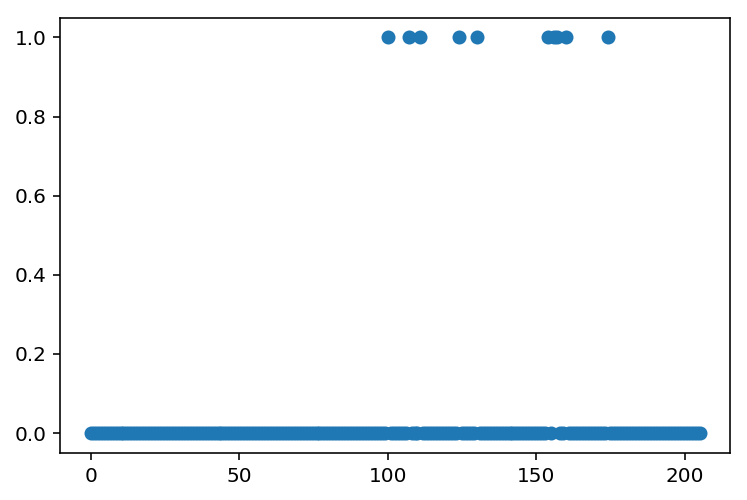

In [17]:
plt.plot(r,'o')

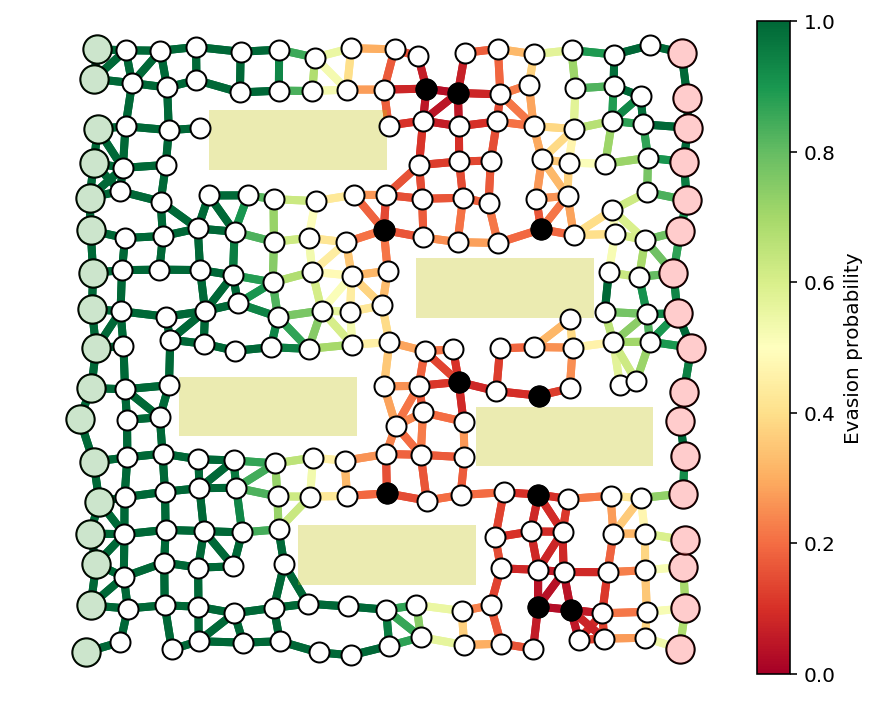

In [18]:
c = edgeVals.dot(r)
edgeProbs = np.exp(c)

guards = [guardIdxs[i] for i in range(len(guardIdxs)) if r[i] > .5]

fig, ax = showPaths(G,pos,edgeProbs,visibleNodes=visibleNodes,Gnodes=Gnodes,Rnodes=Rnodes,guards=guards)
for x,y,w,h in buildings:
    rect = plt.Rectangle((x,y),w,h,fc='y',alpha=.3)
    ax.add_patch(rect)

The evasion probability of the smuggler's optimal path is 4.944881e-06.


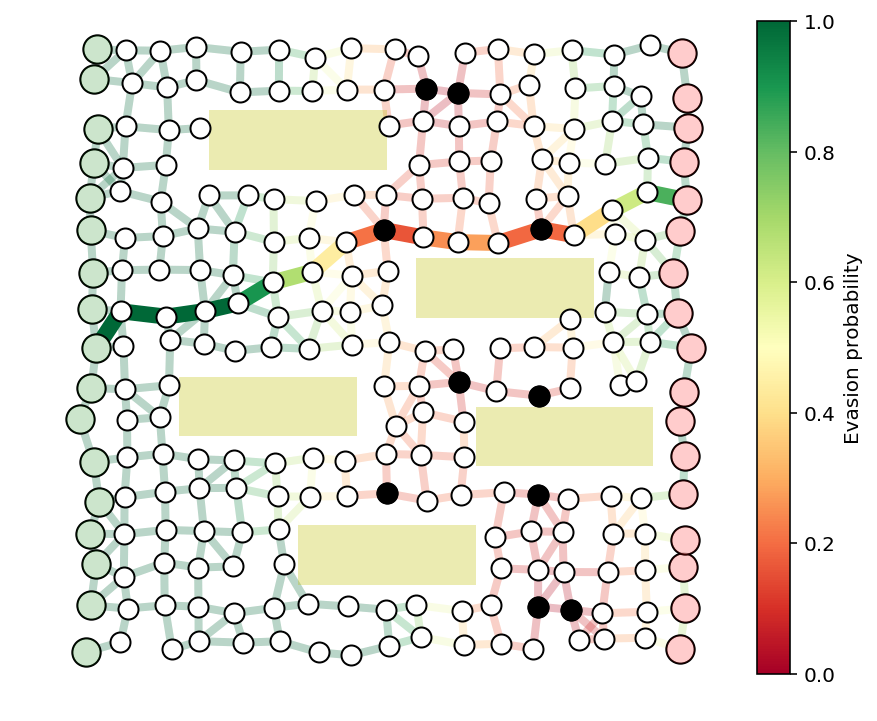

In [19]:
x = optPath(G,edgeProbs)
path_inds = list(np.flatnonzero(x > .1))
fig, ax = showPaths(G,pos,edgeProbs,path=path_inds,visibleNodes=visibleNodes,Gnodes=Gnodes,Rnodes=Rnodes,guards=guards)
print("The evasion probability of the smuggler's optimal path is %e."%(np.exp(x.dot(c)),))
for x,y,w,h in buildings:
    rect = plt.Rectangle((x,y),w,h,fc='y',alpha=.3)
    ax.add_patch(rect)